See code at https://github.com/google-research/vision_transformer/

See papers at

- Vision Transformer: https://arxiv.org/abs/2010.11929
- MLP-Mixer: https://arxiv.org/abs/2105.01601
- How to train your ViT: https://arxiv.org/abs/2106.10270
- When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations: https://arxiv.org/abs/2106.01548

This Colab allows you to run the [JAX](https://jax.readthedocs.org) implementation of the Vision Transformer.

If you just want to load a pre-trained checkpoint from a large repository and
directly use it for inference, you probably want to go [this Colab](https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax_augreg.ipynb).

##### Copyright 2021 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [2]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Already up to date.


In [3]:
# Colab already includes most of the dependencies, so we only install the delta:
#!pip install einops>=0.3.0 ml-collections>=0.1.0 aqtp>=0.2.0 clu>=0.0.3 git+https://github.com/google/flaxformer tensorflow-text>=2.9.0

!pip install -qr vision_transformer/vit_jax/requirements.txt

### Imports

In [6]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

zsh:1: no matches found: gs://vit_models/imagenet*
 330.3 MiB  2021-07-13T19:39:09Z  gs://vit_models/sam/ViT-B_16.npz
336.61 MiB  2021-07-13T19:39:10Z  gs://vit_models/sam/ViT-B_32.npz
  1.13 GiB  2021-07-13T19:39:38Z  gs://vit_models/sam/ViT-L_16.npz
  1.14 GiB  2021-07-13T19:39:38Z  gs://vit_models/sam/ViT-L_32.npz
252.57 MiB  2022-02-18T06:43:52Z  gs://vit_models/sam/ViT-S_16.npz
TOTAL: 5 objects, 3407859850 bytes (3.17 GiB)
zsh:1: no matches found: gs://mixer_models/*


In [7]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'ViT-B_32'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

Copying gs://vit_models/imagenet21k/ViT-B_32.npz...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][400.0 MiB/400.0 MiB]   23.5 MiB/s                                   
Operation completed over 1 objects/400.0 MiB.                                    


In [8]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')

No TPU detected. Can be changed under "Runtime/Change runtime type".


In [10]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[CpuDevice(id=0)]

In [11]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

INFO:absl:Created `ArrayHandler` with primary_host=0, replica_id=0
2024-09-05 09:04:20.018565: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-05 09:04:20.026895: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-05 09:04:20.029335: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-05 09:04:20.514433: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [12]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load dataset

In [13]:
dataset = 'cifar10'
batch_size = 512
config = common_config.with_dataset(common_config.get_config(), dataset)
config.batch = batch_size
config.pp.crop = 224

In [14]:
# For details about setting up datasets, see input_pipeline.py on the right.
ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
del config  # Only needed to instantiate datasets.

2024-09-05 09:04:39.989755: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata.google.internal".
INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: cifar10/3.0.2
INFO:absl:Load dataset info from /tmp/tmp4oskqk49tfds
INFO:absl:For 'cifar10/3.0.2': fields info.[citation, splits, supervised_keys, module_name] differ on disk and in the code. Keeping the one from code.
INFO:absl:Generating dataset cifar10 (/home/ayrton/tensorflow_datasets/cifar10/3.0.2)


/home/ayrton/Code/2JITsu/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]INFO:absl:Downloading https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz into /home/ayrton/tensorflow_datasets/downloads/cs.toronto.edu_kriz_cifar-10-binaryODHPtIjLh3oLcXirEISTO7dkzyKjRCuol6lV8Wc6C7s.tar.gz.tmp.7a2030f776a04caeb140bc29be2e07eb...
Dl Completed...:   0%|                                                                                                                                    | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Size...:   0%|                                                                                                                               

Dataset cifar10 downloaded and prepared to /home/ayrton/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [15]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

2024-09-05 09:05:04.129311: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


(1, 512, 224, 224, 3)

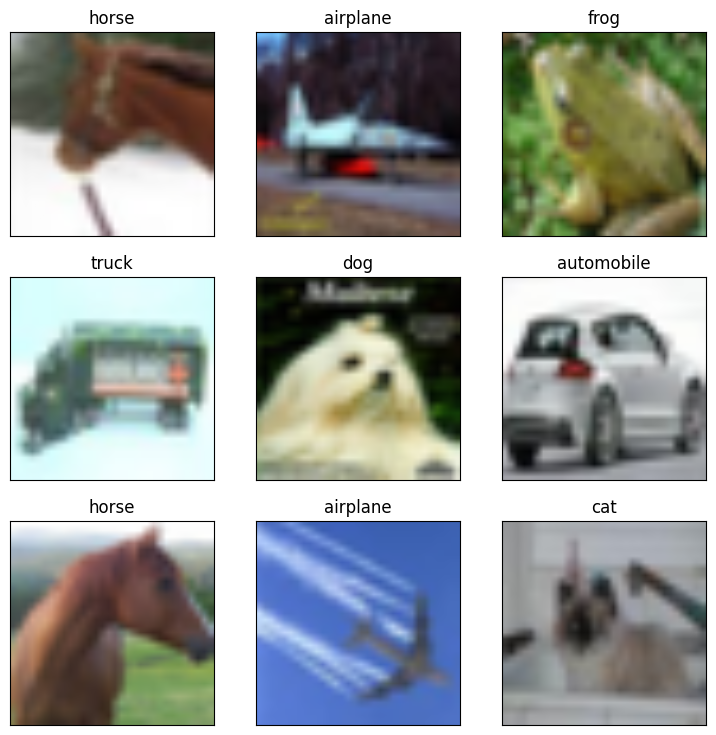

In [16]:
# Show some images with their labels.
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

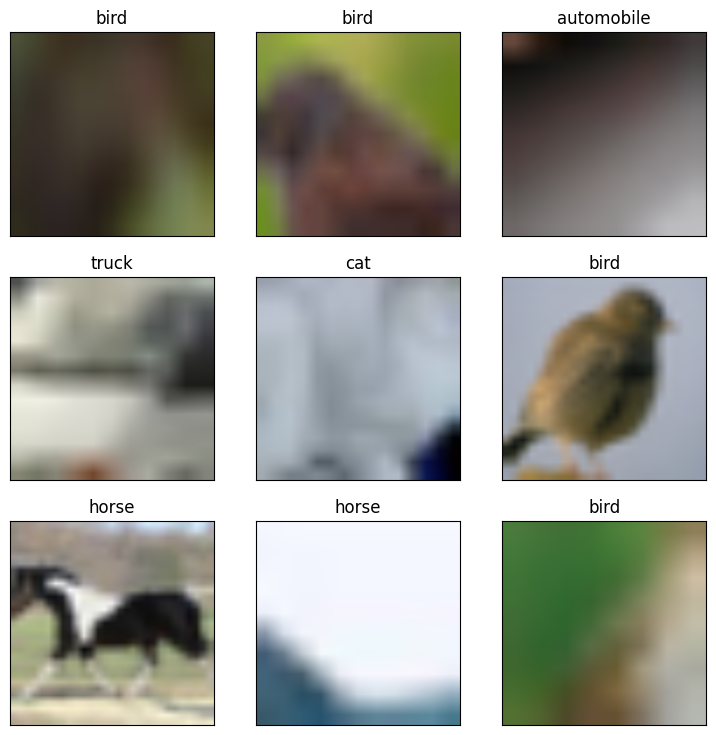

In [17]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Load pre-trained

In [18]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [19]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [20]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

INFO:absl:Inspect extra keys:
{'pre_logits/bias', 'pre_logits/kernel'}
INFO:absl:load_pretrained: drop-head variant


### Evaluate

In [21]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: ArrayImpl (10,)
params_repl.cls: ArrayImpl (1, 10)


In [22]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [23]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [24]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

INFO:absl:Load dataset info from /home/ayrton/tensorflow_datasets/cifar10/3.0.2
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [02:38<00:00,  8.32s/it]


Array(0.10063734, dtype=float32)

### Fine-tune

In [25]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [26]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)
opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

In [27]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

In [28]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

  5%|██████▉                                                                                                                                    | 5/100 [08:02<2:32:48, 96.51s/it]


KeyboardInterrupt: 

In [29]:
# Should be ~96.7% for Mixer-B/16 or 97.7% for ViT-B/32 on CIFAR10 (both @224)
get_accuracy(params_repl)

INFO:absl:Load dataset info from /home/ayrton/tensorflow_datasets/cifar10/3.0.2
  0%|                                                                                                                                                      | 0/19 [00:00<?, ?it/s]


ValueError: INVALID_ARGUMENT: Invalid buffer passed: buffer has been deleted or donated.

### Inference

In [30]:
# Download a pre-trained model.

if model_name.startswith('Mixer'):
  # Download model trained on imagenet2012
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://mixer_models/imagenet1k/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.MlpMixer(num_classes=1000, **model_config)
else:
  # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.VisionTransformer(num_classes=1000, **model_config)

import os
assert os.path.exists(f'{model_name}_imagenet2012.npz')

/usr/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Copying gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz...
==> NOTE: You are downloading one or more large file(s), which would            
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1 files][336.9 MiB/336.9 MiB]   25.8 MiB/s                                   
Operation completed over 1 objects/336.9 MiB.                                    


In [31]:
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model_name}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

In [32]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2024-09-05 09:18:26--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 2607:f8b0:400a:805::201b, 2607:f8b0:400a:806::201b, 2607:f8b0:400a:804::201b, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|2607:f8b0:400a:805::201b|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0.04s   

2024-09-05 09:18:26 (602 KB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



--2024-09-05 09:18:30--  https://picsum.photos/384
Resolving picsum.photos (picsum.photos)... 2606:4700:20::681a:41e, 2606:4700:20::ac43:4aa3, 2606:4700:20::681a:51e, ...
Connecting to picsum.photos (picsum.photos)|2606:4700:20::681a:41e|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://fastly.picsum.photos/id/726/384/384.jpg?hmac=sQPMfW95Ge4gqAI71Kud_sr-UtrtkVDxJTlG4ZG7nyQ [following]
--2024-09-05 09:18:31--  https://fastly.picsum.photos/id/726/384/384.jpg?hmac=sQPMfW95Ge4gqAI71Kud_sr-UtrtkVDxJTlG4ZG7nyQ
Resolving fastly.picsum.photos (fastly.picsum.photos)... 2a04:4e42:5::347, 151.101.21.91
Connecting to fastly.picsum.photos (fastly.picsum.photos)|2a04:4e42:5::347|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18871 (18K) [image/jpeg]
Saving to: ‘picsum.jpg’

picsum.jpg          100%[===================>]  18.43K  --.-KB/s    in 0.005s  

2024-09-05 09:18:32 (3.93 MB/s) - ‘picsum.jpg’ saved [18871/18871]



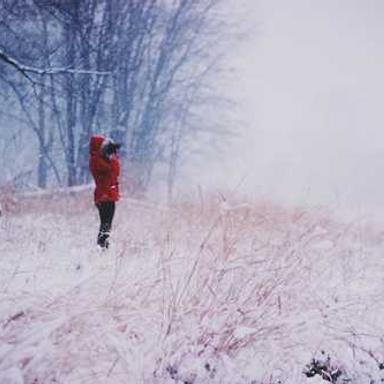

In [33]:
# Get a random picture with the correct dimensions.
resolution = 224 if model_name.startswith('Mixer') else 384
!wget https://picsum.photos/$resolution -O picsum.jpg
import PIL
img = PIL.Image.open('picsum.jpg')
img

In [34]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [35]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.10005 : ski
0.04642 : mountain_bike, all-terrain_bike, off-roader
0.03044 : bow
0.02976 : alp
0.02340 : Leonberg
0.02139 : dogsled, dog_sled, dog_sleigh
0.02122 : Scottish_deerhound, deerhound
0.02011 : lakeside, lakeshore
0.01968 : black_grouse
0.01818 : valley, vale
